## Trader Performance vs Market Sentiment Analysis Data Science Intern Assignment - Primetrade.ai

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from scipy import stats

warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)


In [3]:
print("="*80)
print("TRADER PERFORMANCE VS MARKET SENTIMENT ANALYSIS")
print("="*80)
print("\nStarting analysis...\n")

TRADER PERFORMANCE VS MARKET SENTIMENT ANALYSIS

Starting analysis...



In [5]:
 #Load Fear & Greed Index data
sentiment_df = pd.read_csv('Downloads/fear_greed_index.csv')
print(f"✓ Sentiment data loaded: {sentiment_df.shape[0]:,} rows")

✓ Sentiment data loaded: 2,644 rows


In [55]:
sentiment_df.head()

,timestamp,value,classification,date,sentiment_binary
0,1517463000,30,Fear,2018-02-01,Fear
1,1517549400,15,Extreme Fear,2018-02-02,Fear
2,1517635800,40,Fear,2018-02-03,Fear
3,1517722200,24,Extreme Fear,2018-02-04,Fear
4,1517808600,11,Extreme Fear,2018-02-05,Fear


In [6]:
# Load Historical Trader Data
trader_df = pd.read_csv('Downloads/historical_data.csv')
print(f"✓ Trader data loaded: {trader_df.shape[0]:,} rows")

✓ Trader data loaded: 211,224 rows


In [56]:
trader_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.8700,7872.1600,BUY,2024-12-02 22:50:00,0.0000,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.3454,895000000000000.0000,1730000000000.0000,2024-12-02
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.0000,127.6800,BUY,2024-12-02 22:50:00,986.5246,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.0056,443000000000000.0000,1730000000000.0000,2024-12-02
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.0900,1150.6300,BUY,2024-12-02 22:50:00,1002.5190,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.0504,660000000000000.0000,1730000000000.0000,2024-12-02
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.9800,1142.0400,BUY,2024-12-02 22:50:00,1146.5586,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.0500,1080000000000000.0000,1730000000000.0000,2024-12-02
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.7300,69.7500,BUY,2024-12-02 22:50:00,1289.4885,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.0031,1050000000000000.0000,1730000000000.0000,2024-12-02


In [7]:
# Clean sentiment data
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df = sentiment_df.drop_duplicates(subset=['date'], keep='last')
sentiment_df = sentiment_df.sort_values('date').reset_index(drop=True)

In [8]:
sentiment_df['sentiment_binary'] = sentiment_df['classification'].apply(
    lambda x: 'Fear' if 'Fear' in x else 'Greed'
)

In [9]:
# Clean trader data
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')
trader_df['date'] = trader_df['Timestamp IST'].dt.date
trader_df['date'] = pd.to_datetime(trader_df['date'])

In [10]:
trader_df = trader_df.dropna(subset=['Timestamp IST'])

In [11]:
numeric_cols = ['Execution Price', 'Size Tokens', 'Size USD', 'Closed PnL', 'Fee']
for col in numeric_cols:
    trader_df[col] = pd.to_numeric(trader_df[col], errors='coerce')

In [12]:
# Remove duplicates
initial_rows = len(trader_df)
trader_df = trader_df.drop_duplicates()
print(f"✓ Removed {initial_rows - len(trader_df):,} duplicate rows")

✓ Removed 0 duplicate rows


In [13]:
trader_df['Closed PnL'] = trader_df['Closed PnL'].fillna(0)

In [14]:
# Merge datasets
merged_df = trader_df.merge(
    sentiment_df[['date', 'sentiment_binary', 'classification', 'value']], 
    on='date', 
    how='left'
)

In [15]:
merged_df = merged_df.dropna(subset=['sentiment_binary'])
print(f"✓ Final dataset: {merged_df.shape[0]:,} rows")

✓ Final dataset: 211,218 rows


In [16]:
# Calculate daily metrics per trader
daily_trader_metrics = merged_df.groupby(['date', 'Account', 'sentiment_binary']).agg({
    'Closed PnL': ['sum', 'mean', 'std', 'count'],
    'Size USD': ['sum', 'mean'],
    'Fee': 'sum',
    'Side': lambda x: (x == 'BUY').sum() / len(x) if len(x) > 0 else 0
}).reset_index()

In [17]:
daily_trader_metrics.columns = ['date', 'Account', 'sentiment_binary', 
                                  'daily_pnl', 'avg_pnl_per_trade', 'pnl_volatility', 'num_trades',
                                  'total_volume', 'avg_trade_size', 'total_fees', 'long_ratio']


In [18]:
wins = merged_df[merged_df['Closed PnL'] > 0].groupby(['date', 'Account']).size().reset_index(name='wins')
daily_trader_metrics = daily_trader_metrics.merge(wins, on=['date', 'Account'], how='left')
daily_trader_metrics['wins'] = daily_trader_metrics['wins'].fillna(0)
daily_trader_metrics['win_rate'] = daily_trader_metrics['wins'] / daily_trader_metrics['num_trades']

In [19]:
# Net PnL
daily_trader_metrics['net_pnl'] = daily_trader_metrics['daily_pnl'] - daily_trader_metrics['total_fees']

In [20]:
trader_characteristics = merged_df.groupby('Account').agg({
    'Closed PnL': ['sum', 'mean', 'std'],
    'Size USD': 'mean',
    'Trade ID': 'count',
    'date': lambda x: x.nunique()
}).reset_index()

In [21]:
trader_characteristics.columns = ['Account', 'total_pnl', 'avg_pnl', 'pnl_std', 
                                    'avg_position_size', 'total_trades', 'active_days']


In [22]:
trader_characteristics['trades_per_day'] = trader_characteristics['total_trades'] / trader_characteristics['active_days']


In [23]:
# Calculate win rate per trader
trader_wins = merged_df[merged_df['Closed PnL'] > 0].groupby('Account').size().reset_index(name='total_wins')
trader_characteristics = trader_characteristics.merge(trader_wins, on='Account', how='left')
trader_characteristics['total_wins'] = trader_characteristics['total_wins'].fillna(0)
trader_characteristics['overall_win_rate'] = trader_characteristics['total_wins'] / trader_characteristics['total_trades']

In [24]:
trader_characteristics['is_profitable'] = trader_characteristics['total_pnl'] > 0

In [25]:
freq_median = trader_characteristics['trades_per_day'].median()
trader_characteristics['frequency_segment'] = trader_characteristics['trades_per_day'].apply(
    lambda x: 'High Frequency' if x >= freq_median else 'Low Frequency'
)

In [26]:
trader_characteristics['pnl_consistency'] = np.where(
    trader_characteristics['pnl_std'] / (trader_characteristics['avg_pnl'].abs() + 1) < 
    trader_characteristics['pnl_std'].median() / (trader_characteristics['avg_pnl'].abs() + 1).median(),
    'Consistent',
    'Inconsistent'
)

In [27]:
size_median = trader_characteristics['avg_position_size'].median()
trader_characteristics['size_segment'] = trader_characteristics['avg_position_size'].apply(
    lambda x: 'Large Positions' if x >= size_median else 'Small Positions'
)

In [28]:
# Merge segments back
daily_trader_metrics = daily_trader_metrics.merge(
    trader_characteristics[['Account', 'frequency_segment', 'pnl_consistency', 'size_segment']], 
    on='Account', 
    how='left'
)

In [29]:
print(f"✓ Created metrics for {trader_characteristics.shape[0]:,} traders")

✓ Created metrics for 32 traders


In [30]:
# Save CSV files
daily_trader_metrics.to_csv('daily_trader_metrics.csv', index=False)
trader_characteristics.to_csv('trader_characteristics.csv', index=False)
print("✓ Saved: trader_characteristics.csv")
print("✓ Saved: daily_trader_metrics.csv")

✓ Saved: trader_characteristics.csv
✓ Saved: daily_trader_metrics.csv


In [31]:
performance_by_sentiment = daily_trader_metrics.groupby('sentiment_binary').agg({
    'daily_pnl': ['mean', 'median', 'std'],
    'net_pnl': ['mean', 'median'],
    'win_rate': ['mean', 'median'],
    'num_trades': 'mean',
    'Account': 'count'
}).round(4)

In [32]:
behavior_by_sentiment = daily_trader_metrics.groupby('sentiment_binary').agg({
    'num_trades': ['mean', 'median'],
    'avg_trade_size': ['mean', 'median'],
    'long_ratio': ['mean', 'median'],
    'total_volume': ['mean', 'median']
}).round(4)

segment_analysis = daily_trader_metrics.groupby(['frequency_segment', 'sentiment_binary']).agg({
    'daily_pnl': 'mean',
    'win_rate': 'mean',
    'num_trades': 'mean'
}).round(4)

In [33]:
with pd.ExcelWriter('analysis_summary.xlsx') as writer:
    performance_by_sentiment.to_excel(writer, sheet_name='Performance')
    behavior_by_sentiment.to_excel(writer, sheet_name='Behavior')
    segment_analysis.to_excel(writer, sheet_name='Segments')
    trader_characteristics.describe().to_excel(writer, sheet_name='Trader Stats')

print("✓ Saved: analysis_summary.xlsx")

✓ Saved: analysis_summary.xlsx


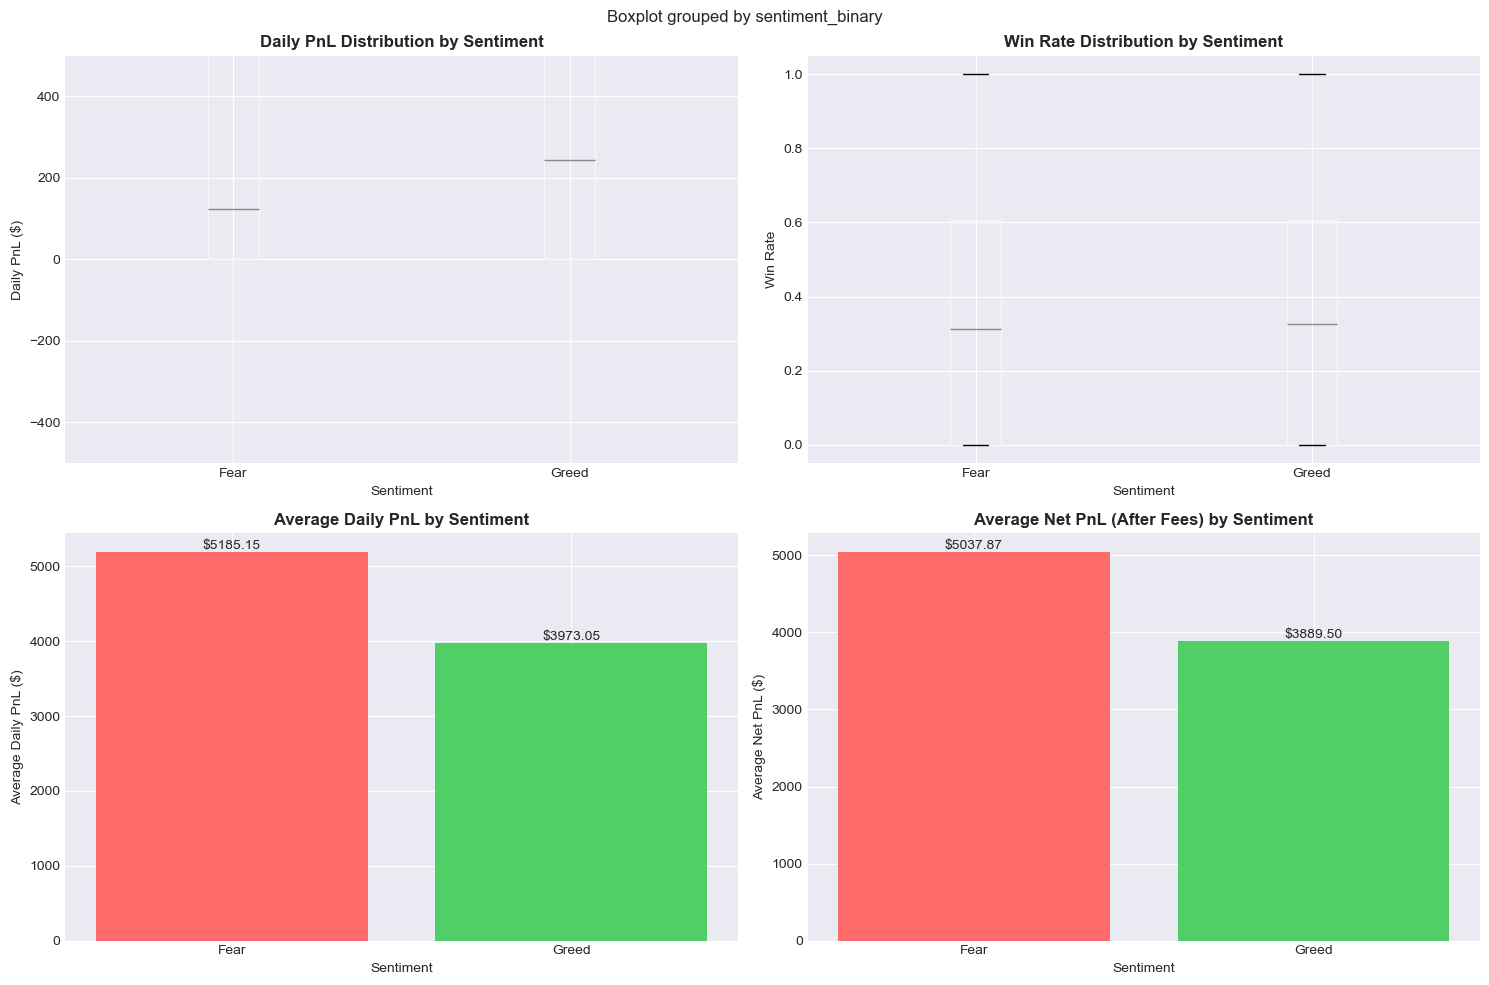

In [39]:
# GENERATE VISUALIZATIONS
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# Daily PnL distribution
daily_trader_metrics.boxplot(column='daily_pnl', by='sentiment_binary', ax=axes[0, 0])
axes[0, 0].set_title('Daily PnL Distribution by Sentiment', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Sentiment')
axes[0, 0].set_ylabel('Daily PnL ($)')
axes[0, 0].set_ylim(-500, 500)
plt.sca(axes[0, 0])
plt.xticks(rotation=0)
# Win rate distribution
daily_trader_metrics.boxplot(column='win_rate', by='sentiment_binary', ax=axes[0, 1])
axes[0, 1].set_title('Win Rate Distribution by Sentiment', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Sentiment')
axes[0, 1].set_ylabel('Win Rate')
plt.sca(axes[0, 1])
plt.xticks(rotation=0)
# Average PnL comparison
avg_pnl = daily_trader_metrics.groupby('sentiment_binary')['daily_pnl'].mean()
axes[1, 0].bar(avg_pnl.index, avg_pnl.values, color=['#ff6b6b', '#51cf66'])
axes[1, 0].set_title('Average Daily PnL by Sentiment', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Sentiment')
axes[1, 0].set_ylabel('Average Daily PnL ($)')
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
for i, v in enumerate(avg_pnl.values):
    axes[1, 0].text(i, v, f'${v:.2f}', ha='center', va='bottom' if v > 0 else 'top')
#  Net PnL (after fees)
net_pnl = daily_trader_metrics.groupby('sentiment_binary')['net_pnl'].mean()
axes[1, 1].bar(net_pnl.index, net_pnl.values, color=['#ff6b6b', '#51cf66'])
axes[1, 1].set_title('Average Net PnL (After Fees) by Sentiment', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Sentiment')
axes[1, 1].set_ylabel('Average Net PnL ($)')
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
for i, v in enumerate(net_pnl.values):
    axes[1, 1].text(i, v, f'${v:.2f}', ha='center', va='bottom' if v > 0 else 'top')

plt.tight_layout()
plt.savefig('performance_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()    

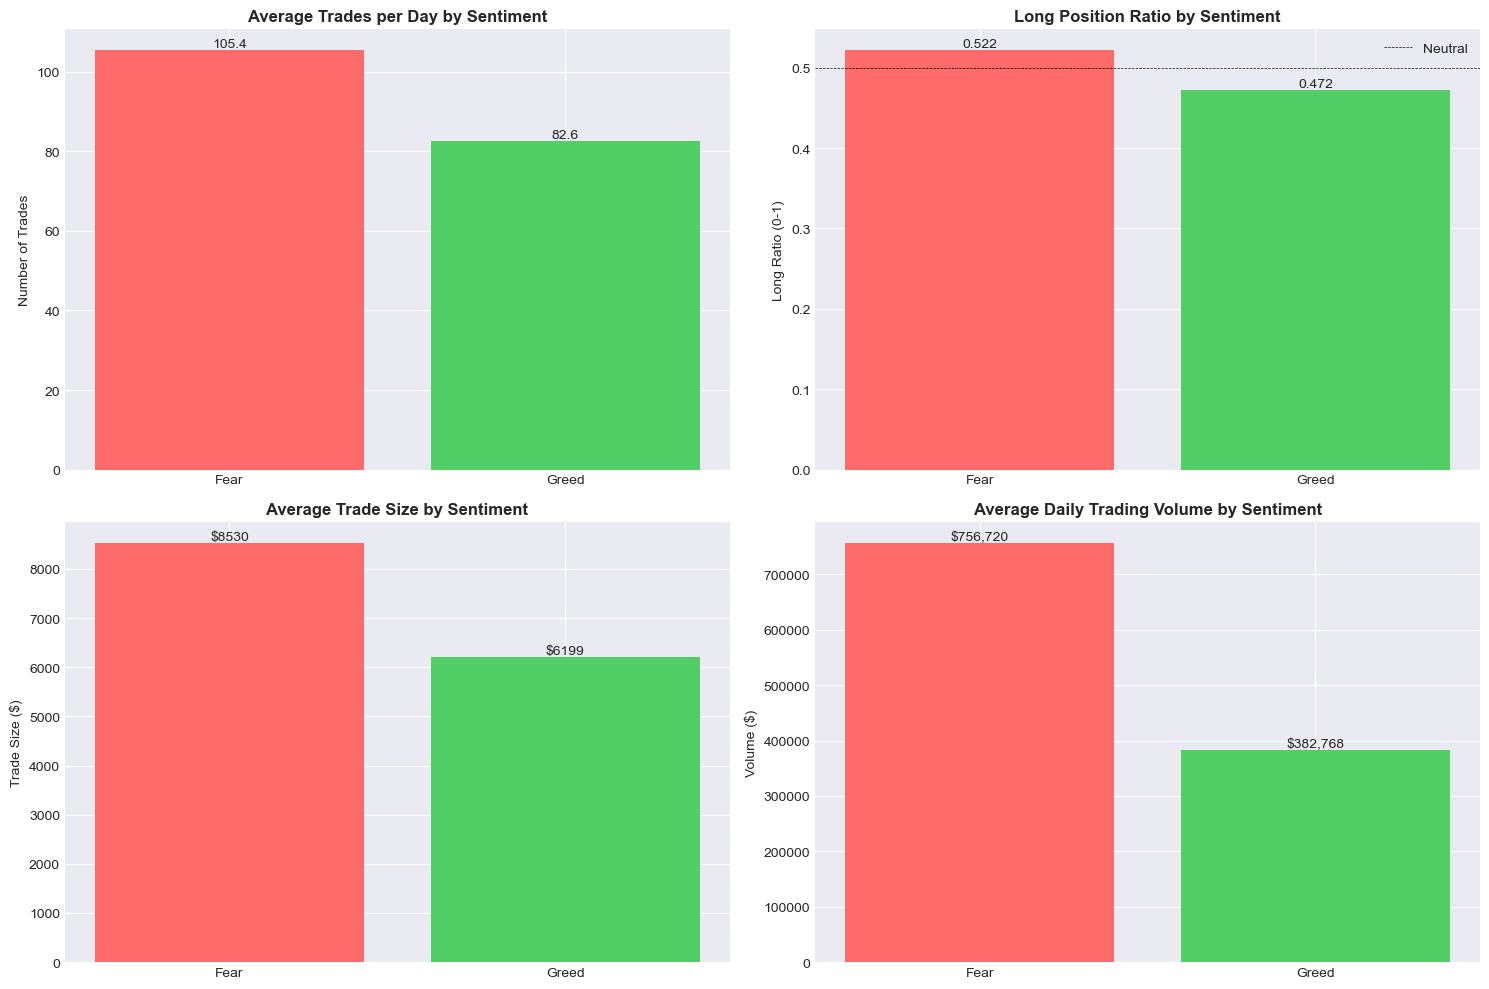

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Trade frequency
trade_freq = daily_trader_metrics.groupby('sentiment_binary')['num_trades'].mean()
axes[0, 0].bar(trade_freq.index, trade_freq.values, color=['#ff6b6b', '#51cf66'])
axes[0, 0].set_title('Average Trades per Day by Sentiment', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Trades')
for i, v in enumerate(trade_freq.values):
    axes[0, 0].text(i, v, f'{v:.1f}', ha='center', va='bottom')

# 2. Long/Short bias
long_bias = daily_trader_metrics.groupby('sentiment_binary')['long_ratio'].mean()
axes[0, 1].bar(long_bias.index, long_bias.values, color=['#ff6b6b', '#51cf66'])
axes[0, 1].set_title('Long Position Ratio by Sentiment', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Long Ratio (0-1)')
axes[0, 1].axhline(y=0.5, color='black', linestyle='--', linewidth=0.5, label='Neutral')
axes[0, 1].legend()
for i, v in enumerate(long_bias.values):
    axes[0, 1].text(i, v, f'{v:.3f}', ha='center', va='bottom')

# 3. Average trade size
trade_size = daily_trader_metrics.groupby('sentiment_binary')['avg_trade_size'].mean()
axes[1, 0].bar(trade_size.index, trade_size.values, color=['#ff6b6b', '#51cf66'])
axes[1, 0].set_title('Average Trade Size by Sentiment', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Trade Size ($)')
for i, v in enumerate(trade_size.values):
    axes[1, 0].text(i, v, f'${v:.0f}', ha='center', va='bottom')

# 4. Total daily volume
volume = daily_trader_metrics.groupby('sentiment_binary')['total_volume'].mean()
axes[1, 1].bar(volume.index, volume.values, color=['#ff6b6b', '#51cf66'])
axes[1, 1].set_title('Average Daily Trading Volume by Sentiment', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Volume ($)')
for i, v in enumerate(volume.values):
    axes[1, 1].text(i, v, f'${v:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('behavior_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

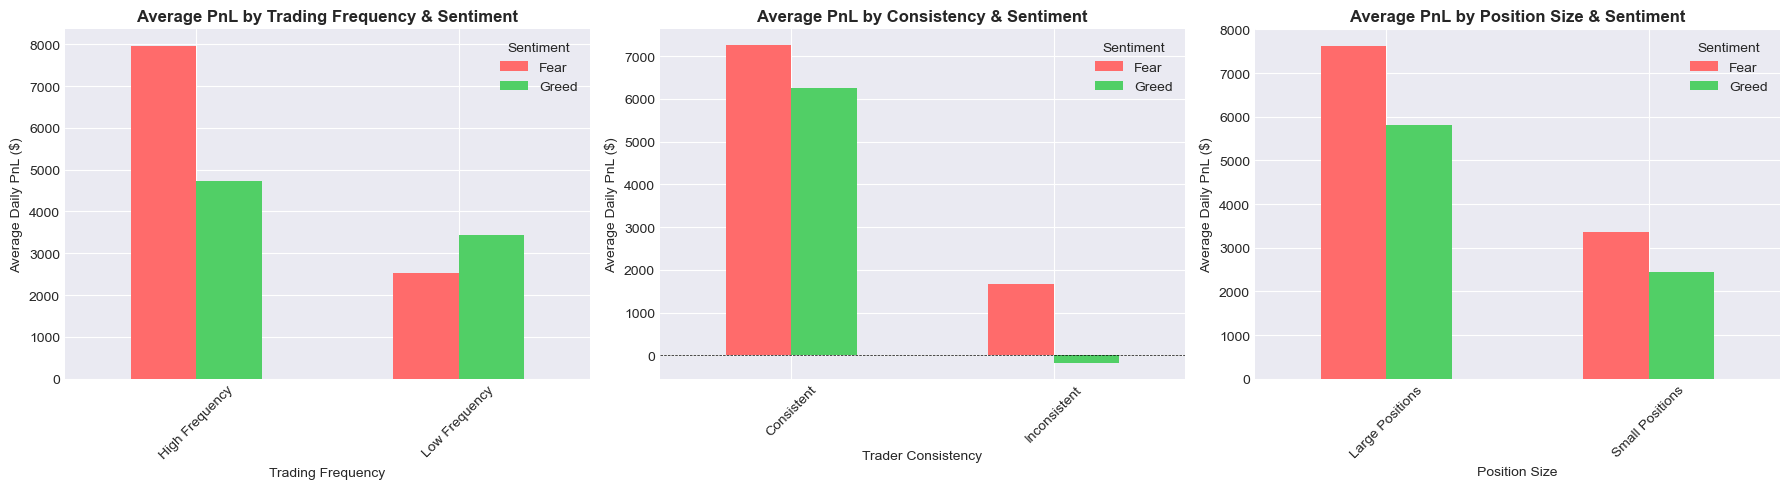

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Segment 1: Frequency
freq_pnl = daily_trader_metrics.groupby(['frequency_segment', 'sentiment_binary'])['daily_pnl'].mean().unstack()
freq_pnl.plot(kind='bar', ax=axes[0], color=['#ff6b6b', '#51cf66'])
axes[0].set_title('Average PnL by Trading Frequency & Sentiment', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Average Daily PnL ($)')
axes[0].set_xlabel('Trading Frequency')
axes[0].legend(title='Sentiment')
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.sca(axes[0])
plt.xticks(rotation=45)

# Segment 2: Consistency
consist_pnl = daily_trader_metrics.groupby(['pnl_consistency', 'sentiment_binary'])['daily_pnl'].mean().unstack()
consist_pnl.plot(kind='bar', ax=axes[1], color=['#ff6b6b', '#51cf66'])
axes[1].set_title('Average PnL by Consistency & Sentiment', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Daily PnL ($)')
axes[1].set_xlabel('Trader Consistency')
axes[1].legend(title='Sentiment')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.sca(axes[1])
plt.xticks(rotation=45)

# Segment 3: Position Size
size_pnl = daily_trader_metrics.groupby(['size_segment', 'sentiment_binary'])['daily_pnl'].mean().unstack()
size_pnl.plot(kind='bar', ax=axes[2], color=['#ff6b6b', '#51cf66'])
axes[2].set_title('Average PnL by Position Size & Sentiment', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Average Daily PnL ($)')
axes[2].set_xlabel('Position Size')
axes[2].legend(title='Sentiment')
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.sca(axes[2])
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('segment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
daily_aggregate = daily_trader_metrics.groupby(['date', 'sentiment_binary']).agg({
    'daily_pnl': 'mean',
    'win_rate': 'mean',
    'num_trades': 'sum'
}).reset_index()

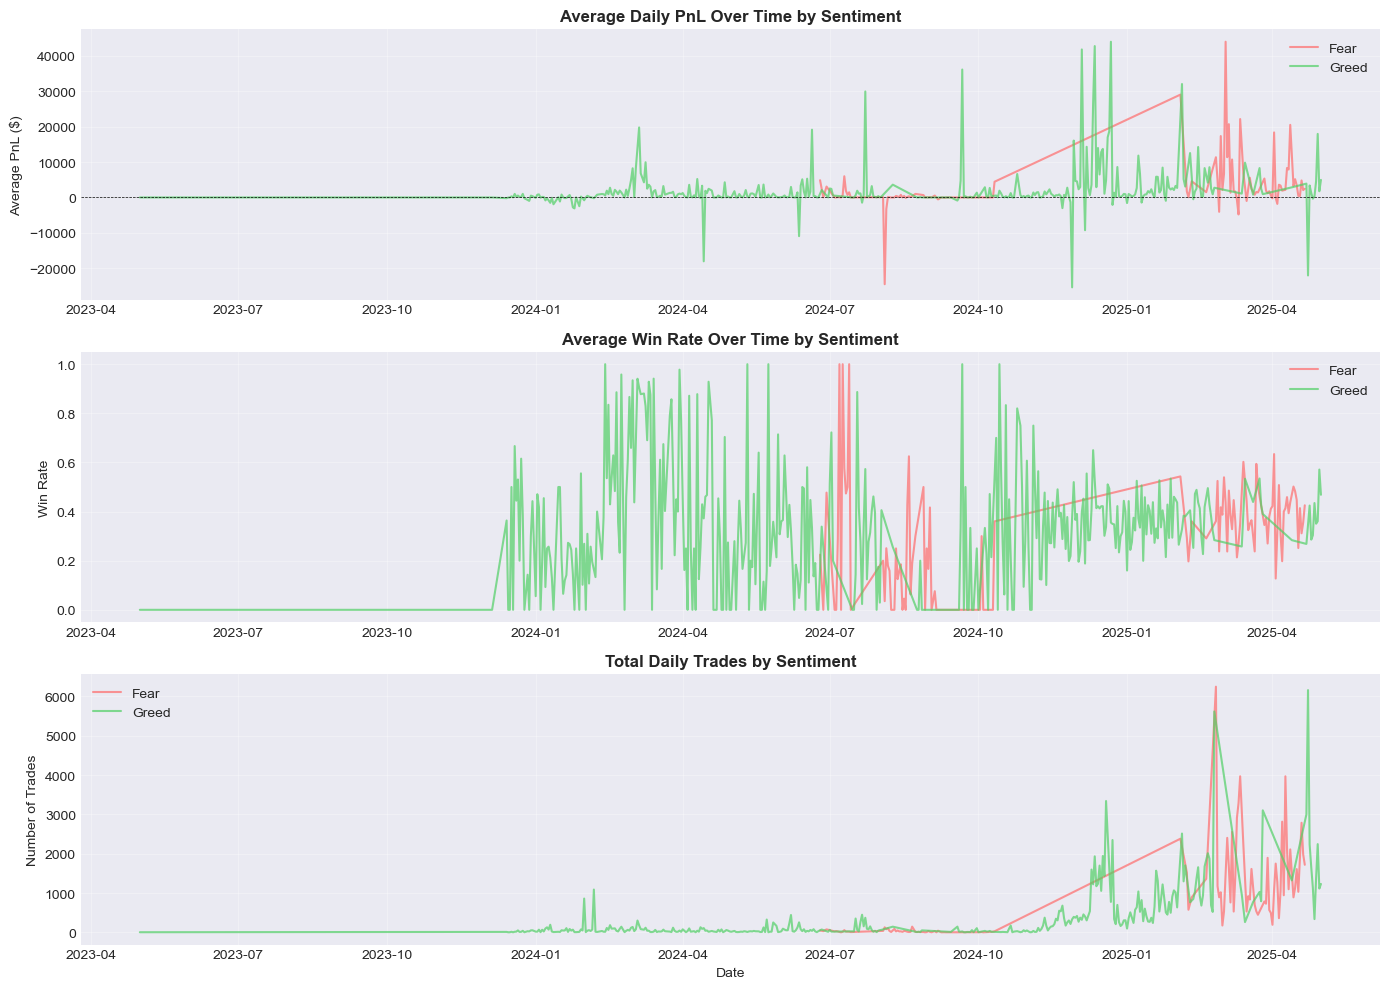

In [46]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Average PnL over time
for sentiment in ['Fear', 'Greed']:
    data = daily_aggregate[daily_aggregate['sentiment_binary'] == sentiment]
    color = '#ff6b6b' if sentiment == 'Fear' else '#51cf66'
    axes[0].plot(data['date'], data['daily_pnl'], label=sentiment, alpha=0.7, color=color)

axes[0].set_title('Average Daily PnL Over Time by Sentiment', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Average PnL ($)')
axes[0].legend()
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
axes[0].grid(True, alpha=0.3)

# Plot 2: Win rate over time
for sentiment in ['Fear', 'Greed']:
    data = daily_aggregate[daily_aggregate['sentiment_binary'] == sentiment]
    color = '#ff6b6b' if sentiment == 'Fear' else '#51cf66'
    axes[1].plot(data['date'], data['win_rate'], label=sentiment, alpha=0.7, color=color)

axes[1].set_title('Average Win Rate Over Time by Sentiment', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Win Rate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Total trades over time
for sentiment in ['Fear', 'Greed']:
    data = daily_aggregate[daily_aggregate['sentiment_binary'] == sentiment]
    color = '#ff6b6b' if sentiment == 'Fear' else '#51cf66'
    axes[2].plot(data['date'], data['num_trades'], label=sentiment, alpha=0.7, color=color)

axes[2].set_title('Total Daily Trades by Sentiment', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Number of Trades')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('time_series_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

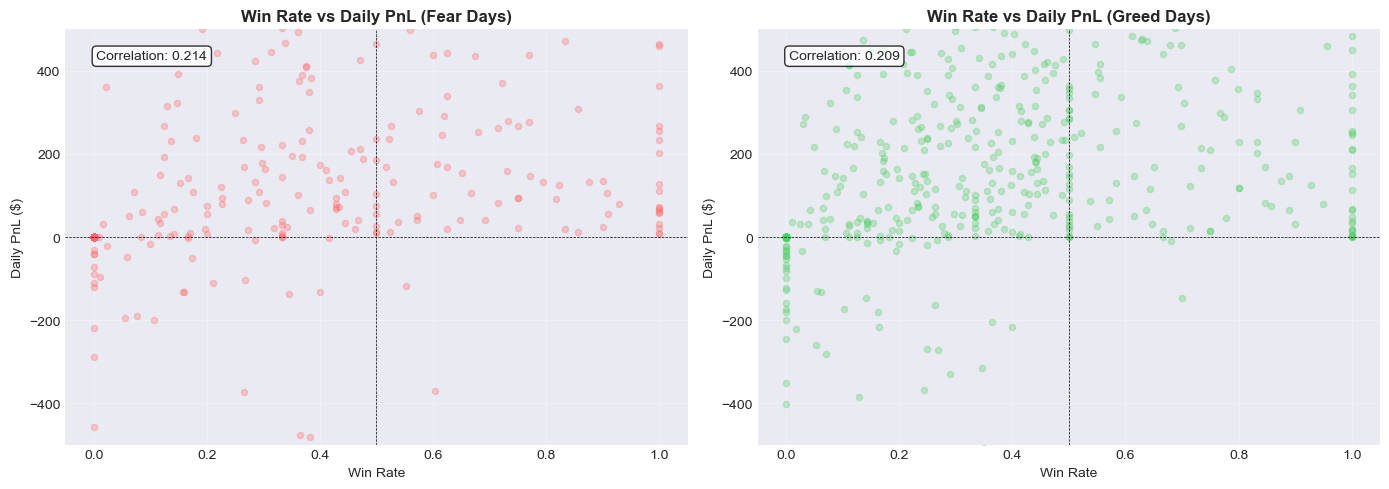

In [47]:
# Win Rate vs PnL Correlation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, sentiment in enumerate(['Fear', 'Greed']):
    data = daily_trader_metrics[daily_trader_metrics['sentiment_binary'] == sentiment]
    color = '#ff6b6b' if sentiment == 'Fear' else '#51cf66'
    
    axes[i].scatter(data['win_rate'], data['daily_pnl'], alpha=0.3, s=20, color=color)
    axes[i].set_title(f'Win Rate vs Daily PnL ({sentiment} Days)', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Win Rate')
    axes[i].set_ylabel('Daily PnL ($)')
    axes[i].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    axes[i].axvline(x=0.5, color='black', linestyle='--', linewidth=0.5)
    axes[i].set_ylim(-500, 500)
    axes[i].grid(True, alpha=0.3)
    
    # Calculate correlation
    corr = data[['win_rate', 'daily_pnl']].corr().iloc[0, 1]
    axes[i].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                transform=axes[i].transAxes, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                verticalalignment='top')

plt.tight_layout()
plt.savefig('winrate_pnl_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

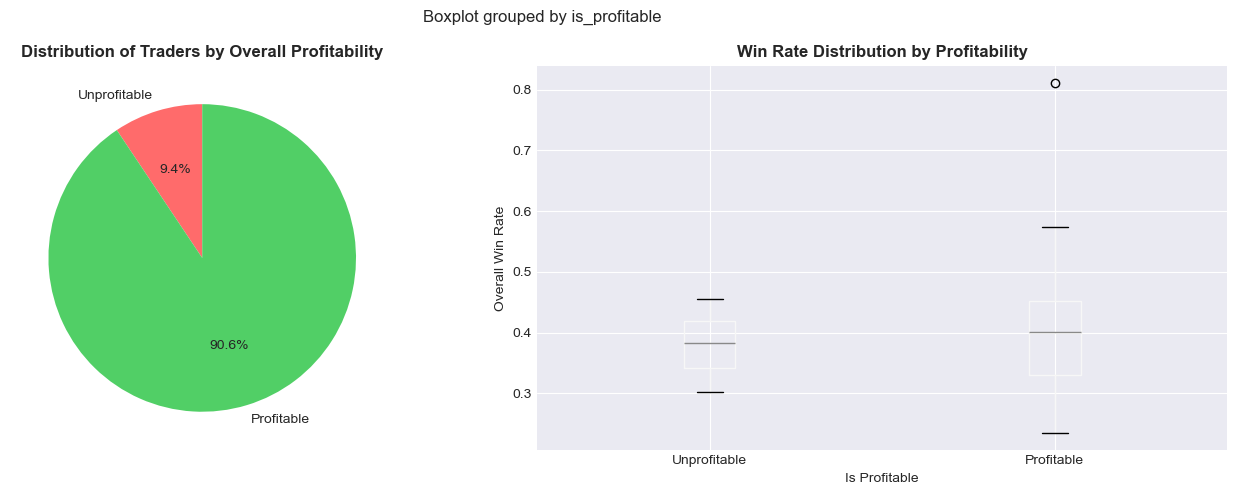

In [54]:
# Profitability Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Profitability distribution
profit_dist = trader_characteristics.groupby('is_profitable').size()
axes[0].pie(profit_dist.values, labels=['Unprofitable', 'Profitable'], 
           autopct='%1.1f%%', colors=['#ff6b6b', '#51cf66'], startangle=90)
axes[0].set_title('Distribution of Traders by Overall Profitability', fontsize=12, fontweight='bold')

# Win rate distribution by profitability
trader_characteristics.boxplot(column='overall_win_rate', by='is_profitable', ax=axes[1])
axes[1].set_title('Win Rate Distribution by Profitability', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Is Profitable')
axes[1].set_ylabel('Overall Win Rate')
plt.sca(axes[1])
plt.xticks([1, 2], ['Unprofitable', 'Profitable'])

plt.tight_layout()
plt.savefig('profitability_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [50]:
print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

print("\n📊 Generated Files:")
print("   Data Exports:")
print("   ✓ daily_trader_metrics.csv")
print("   ✓ trader_characteristics.csv")
print("   ✓ analysis_summary.xlsx")
print("\n   Visualizations:")
print("   ✓ performance_by_sentiment.png")
print("   ✓ behavior_by_sentiment.png")
print("   ✓ segment_analysis.png")
print("   ✓ time_series_analysis.png")
print("   ✓ winrate_pnl_correlation.png")
print("   ✓ profitability_distribution.png")



ANALYSIS COMPLETE!

📊 Generated Files:
   Data Exports:
   ✓ daily_trader_metrics.csv
   ✓ trader_characteristics.csv
   ✓ analysis_summary.xlsx

   Visualizations:
   ✓ performance_by_sentiment.png
   ✓ behavior_by_sentiment.png
   ✓ segment_analysis.png
   ✓ time_series_analysis.png
   ✓ winrate_pnl_correlation.png
   ✓ profitability_distribution.png


## Key Statistics:

In [52]:
fear_days = daily_trader_metrics[daily_trader_metrics['sentiment_binary'] == 'Fear']
greed_days = daily_trader_metrics[daily_trader_metrics['sentiment_binary'] == 'Greed']
print(f"   • Average PnL (Fear): ${fear_days['daily_pnl'].mean():.2f}")
print(f"   • Average PnL (Greed): ${greed_days['daily_pnl'].mean():.2f}")
print(f"   • Win Rate (Fear): {fear_days['win_rate'].mean():.3f}")
print(f"   • Win Rate (Greed): {greed_days['win_rate'].mean():.3f}")
print(f"   • Total Traders: {trader_characteristics.shape[0]:,}")
print(f"   • Profitable Traders: {trader_characteristics['is_profitable'].sum()} ({trader_characteristics['is_profitable'].sum()/len(trader_characteristics)*100:.1f}%)")

   • Average PnL (Fear): $5185.15
   • Average PnL (Greed): $3973.05
   • Win Rate (Fear): 0.357
   • Win Rate (Greed): 0.361
   • Total Traders: 32
   • Profitable Traders: 29 (90.6%)
